In [1]:
import scipy.stats as sta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,vectorize
from ipyparallel import Client
import random
import numpy

In [2]:
from sghmc.module import SGHMC, SGHMC_parallel

In [3]:
import pandas as pd
dieb = pd.read_fwf('diab.txt')
dieb = dieb.drop("Unnamed: 6", axis=1)
dieb = dieb.drop("diabetes", axis=1)
dieb = dieb[['glu','npreg','bp skin','bmi','ped age']]
data = dieb.to_numpy()
X = data[:,1:]
glu = data[:,0]

In [4]:
def gradU3(scale,theta,batch):
    '''compute gradient of U for linear model'''
    
    def logposterior(parameter, data, alpha_prior_m=0, alpha_prior_sd=10, beta_prior_m=1, beta_prior_sd=10, logs2_prior_m=0, logs2_prior_sd=10):
        '''
    
        Compute the log density of data and gradient of log density of data
        Parameter: beta and log variance (p+1,1)
        X: data matrix (n,p)
        Y: response (n,1)
        ..._prior_m = prior mean of elts in parameters
        ..._prior_sd = prior standard error of elts in parameters
    
        '''
    
        def normal_prior(p, mu, s):
            '''compute the log prior and gradient of log prior'''
            Z = (p-mu)/s
            logpdf = numpy.sum(-numpy.log(s) - 0.5*numpy.log(2*numpy.pi)-0.5*Z**2, axis=0)
            grad_logpdf = -Z/s
        
            return logpdf.reshape(-1,1), grad_logpdf.reshape(-1,1)
    
        Y = data[:,0].reshape(-1,1)
        X = data[:,1:]
    
        alpha = parameter[0]
        beta = parameter[1:parameter.shape[0]-1]
        beta = beta.reshape(-1,1)
        logs2 = parameter[parameter.shape[0]-1]
    
        # compute log likelihood and gradient
        sigma = numpy.sqrt(numpy.exp(logs2))
        mu = X @ beta + alpha
        Z = (Y-mu)/sigma
    
        grad_alpha1 = numpy.sum(Z/sigma)
        grad_beta1 = X.T @ Z/sigma
        grad_logs21 = numpy.sum(-0.5 + 0.5*Z**2)
    
        # compute log priors and gradient
        log_prior_alpha, grad_lp_alpha = normal_prior(alpha, alpha_prior_m, alpha_prior_sd)
        log_prior_beta, grad_lp_beta = normal_prior(beta, beta_prior_m, beta_prior_sd)
        log_prior_logs2, grad_lp_logs2 = normal_prior(logs2, logs2_prior_m, logs2_prior_sd)
        log_prior = log_prior_alpha + log_prior_beta + log_prior_logs2 # '+' in matlab
    
        # log posterior and gradient
        grad_alpha = grad_alpha1 + grad_lp_alpha
        grad_beta = grad_beta1 + grad_lp_beta
        grad_logs2 = grad_logs21 + grad_lp_logs2
        grad_log_post = numpy.hstack((grad_alpha[0], grad_beta[:,0], grad_logs2[0]))
    
        return grad_log_post
    
    return - scale*logposterior(theta, batch)

In [5]:
theta1 = SGHMC(theta0=np.ones(6), X = data, gradU = gradU3, eps=0.01, sample_size=2000, B=0.01, C=np.eye(6), batch_size=20,burnin=500)

In [6]:
post_coef_m = np.mean(theta1, axis=0)
est_coef = post_coef_m[:post_coef_m.shape[0]-1]
est_coef

array([3.60839387, 0.9493858 , 0.83976376, 0.14868943, 1.4741197 ])

In [7]:
est_glu = est_coef[0] + X @ est_coef[1:]

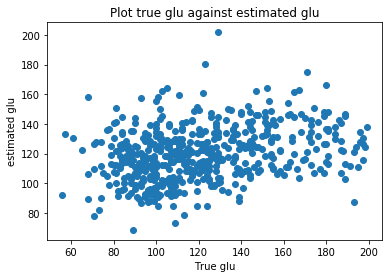

In [8]:
plt.scatter(glu,est_glu)
plt.xlabel('True glu')
plt.ylabel('estimated glu')
plt.title('Plot true glu against estimated glu')
plt.savefig('glu_estimation.png')

In [9]:
theta2 = SGHMC_parallel(theta0=np.ones(6), X = data, gradU = gradU3, eps=0.01, sample_size=2000, B=0.01, C=np.eye(6), batch_size=20,burnin=500)

importing numpy on engine(s)


In [10]:
post_coef_m = np.mean(theta2, axis=0)
est_coef = post_coef_m[:post_coef_m.shape[0]-1]
est_coef

array([3.24257539, 1.00452786, 0.83755161, 0.14162745, 1.48882532])

In [11]:
est_glu = est_coef[0] + X @ est_coef[1:]

Text(0.5, 1.0, 'Plot true glu against estimated glu')

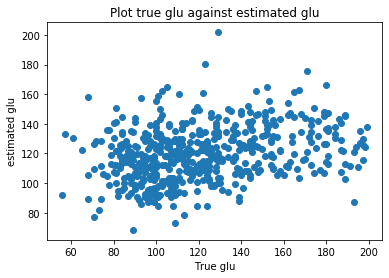

In [12]:
plt.scatter(glu,est_glu)
plt.xlabel('True glu')
plt.ylabel('estimated glu')
plt.title('Plot true glu against estimated glu')